In [ ]:
########################################################################################
## Author: Marti JIMENEZ                                                              ##
## Date: 01/08/2023                                                                   ##
## Institution: INSA (National Institute of Applied Sciences) Toulouse, France        ##
## License: Open-source                                                               ##
##                                                                                    ##
##                                                                                    ##
## The code:                                                                          ##
##              This code solves n-Dimensional Partial Differential Equations         ##
##                          with Physics-Informed Neural Networks                     ##
##                                                                                    ##
##                                                                                    ##
## Example:                                                                           ##
##              As an example we solved the Fisher-KPP equation in 2 Dimensions       ##
##                                                                                    ##
##                      du/dt = D*( d²u/dx² + d²u/dy² ) + r*u*(1-u)                   ##
##                                                                                    ##
########################################################################################

# Define the PDE, BC and IC


In [27]:
######################## Imports ########################
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
#########################################################



######################## DIMENSIONS AND VARIABLE BOUNDARIES ########################
DIMENSIONS = 3 # number of dimensions of the PDE
BOUNDARIES = [
                [0.0, 5.0],  # Time boundaries
                [0.0, 1.0],  # x boundaries
                [0.0, 1.0],  # y boundaries
                # Add more boundaries for additional dimensions if needed
            ]
####################################################################################



######################## NEURAL NETWORK ########################
NUMBER_HIDDEN_LAYERS = 4 # number of hidden layers in the neural network
NUMBER_NEURONS_PER_LAYER = 20 # number of neurons per hidden layer
NUMBER_DATA_POINTS_PDE = 10000 # number of random data points
NUMBER_DATA_POINTS_INITIAL_CONDITION = 1000 # number of random initial condition data points
NUMBER_DATA_POINTS_BOUNDARY_CONDITION = 1000 # number of random boundary condition data points
NUMBER_TRAINING_EPOCHS = 20000 # number of training iterations
LEARNING_RATE = [1e-2,5e-3,1e-3,5e-4,1e-4] # learning rates of the NN
EPOCH_CHECKPOINTS_CHANGE_LEARNING_RATE = [2000,5000,12500,17500] # at which iteration to change the learning rate
PRINT_LOSS_INTERVAL = 10 # print the loss every PRINT_LOSS_INTERVAL training steps
CHEKPOINT_PATH = 'model_checkpoint' #path to save the model
CHECKPOINT_ITERATIONS = 100 # save the model each CHECKPOINT_ITERATIONS iterations
##################################################################



######################## DATA TYPE ########################
DTYPE='float32' # Set data type
tf.keras.backend.set_floatx(DTYPE)
PLOT_LOSS_HISTORY = True # boolean to plot or not plot the loss history after training
###########################################################



######################## PARAMETERS ########################
pi = tf.constant(np.pi)
a = 0.02
############################################################



######################## Define initial condition ########################
def comp_i(X):
    x = X[:,1:2]
    y = X[:,2:3]
    return tf.exp(-((x-0.5)**2+(y-0.5)**2)/0.08)



######################## Define Neumann boundary condition ########################
NEUMANN_BOUNDARY_CONDITION = 0 # the Neumann BC



######################## Define residual of the PDE ########################
def comp_r(var, u, first_deriv, second_deriv):
    """
        var: [t,x,y,z,...]
        u: output of the nn (predicted value of the PDE)
        first_deriv: [u_t, u_x, u_y, u_z,...]
        second_deriv: [u_tt, u_xx, u_yy, u_zz,...]
    """
    u_t = first_deriv[0]
    u_xx, u_yy = second_deriv[1], second_deriv[2]
    return u_t - a*(u_xx+u_yy) - u*(1-u)

#

In [28]:
######################## residual of boundary condition ########################
def comp_b(var, first_derivatives, lower_boundary, upper_boundary):

    neumann_boundary_condition = NEUMANN_BOUNDARY_CONDITION

    return_tensor = tf.zeros_like(var[1]) # init the return tensor

    for i in range(1,len(var)): # we start from 1 to skip the time variable
        comparison_tensor = tf.equal(var[i], [lower_boundary[i],upper_boundary[i]]) # is our tensor on the boundaries?
        return_tensor += tf.where(
                                    comparison_tensor, 
                                    [first_derivatives[i]-neumann_boundary_condition,first_derivatives[i]-neumann_boundary_condition], 
                                    0
                                ) # if it is in the boundary then return the first derivative of that variable minus the neumann BC, if not 0

    return return_tensor

# Creation of the Data sets

In [29]:
################ Prepare the sets of data ################

# Set the number of data points for initial condition, boundary, and PDE data
N_0 = NUMBER_DATA_POINTS_INITIAL_CONDITION  # Number of initial condition data points
N_b = NUMBER_DATA_POINTS_BOUNDARY_CONDITION  # Number of boundary data points
N_r = NUMBER_DATA_POINTS_PDE  # Number of PDE data points

# Define the boundaries for each dimension
boundaries = BOUNDARIES

# Set the lower and upper bounds as tensors
lb = tf.constant([boundaries[i][0] for i in range(len(boundaries))], dtype=DTYPE)  # Lower bounds
ub = tf.constant([boundaries[i][1] for i in range(len(boundaries))], dtype=DTYPE)  # Upper bounds


################ Set random seed for reproducible results or remove it for different results ################
tf.random.set_seed(0)



################################ Initial data ################################
t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]  # Time values for initial condition
other_0 = tf.random.uniform((N_0, DIMENSIONS-1), lb[1:], ub[1:], dtype=DTYPE)  # Random spatial values for initial condition
X_0 = tf.concat([t_0, other_0], axis=1) # Initial Condtition points




################################ Boundary data ################################
t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)  # Random time values for boundary data
other_b = lb[1:] + (ub[1:] - lb[1:]) * tf.keras.backend.random_bernoulli((N_b, DIMENSIONS-1), 0.5, dtype=DTYPE)  # Spatial corner boundary values (or boundary values for 2 Dimensions)
X_b = tf.concat([t_b, other_b], axis=1) # Boundary Condition Points

# if we are in 2 DIMENSIONS we already have the BC points with the lines above

if DIMENSIONS==3: # for 3 dimensions we do manually the x and y boundaries
    # for x boundary
    x_boundary = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)  # Spatial boundary values 
    y_random = tf.random.uniform((N_b, 1), lb[2], ub[2], dtype=DTYPE)  # Random spatial values to concat with the Boundary Condition points
    points_for_x_boundary = tf.concat([t_b,x_boundary,y_random], axis=1) # build the points for the x boundary
   
    # for y boundary
    y_boundary = lb[2] + (ub[2] - lb[2]) * tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)  # Spatial boundary values 
    x_random = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype=DTYPE)  # Random spatial values to concat with the Boundary Condition points
    points_for_y_boundary = tf.concat([t_b,x_random,y_boundary], axis=1) # build the points for the x boundary

    updated_X_b = tf.concat([X_b, points_for_x_boundary, points_for_y_boundary], axis=0) # add this Boundary Condition Points to the other
    X_b = updated_X_b # update the points


else: # for anything greater than 3 dimensions we can automate the process

    for i in range(1,DIMENSIONS): # for each spatial value
        boundary_point_b = lb[i] + (ub[i] - lb[i]) * tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)  # Spatial boundary values 
        random_values = tf.random.uniform((N_b, DIMENSIONS-2), lb[i], ub[i], dtype=DTYPE)  # Random spatial values to concat with the Boundary Condition points
        tensor_left = random_values[:, :i-1]
        tensor_right = random_values[:, i-1:]
        points_for_this_variable = tf.concat([t_b,tensor_left,boundary_point_b,tensor_right], axis=1) # build the points for this variable boundary
        updated_X_b = tf.concat([X_b, points_for_this_variable], axis=0) # add this Boundary Condition Points to the other
        X_b = updated_X_b # update the points





################################ Draw uniformly sampled collocation points ################################
X_r = tf.random.uniform((N_r, DIMENSIONS), lb, ub, dtype=DTYPE)  # Random time and spatial values for PDE data



# Setup NN architecture

In [30]:
################ Setup the NN architecture ################
def init_model(num_hidden_layers=NUMBER_HIDDEN_LAYERS, num_neurons_per_layer=NUMBER_NEURONS_PER_LAYER):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input 
    model.add(tf.keras.Input(DIMENSIONS))

    # Introduce a scaling layer to map [lb, ub] to [0,1]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: (x - lb)/(ub - lb))
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('softmax'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

# Residual, Loss, Gradient loss

In [31]:
################ Get residual of PDE ################
def get_r(model, X_r):

    # Compute derivatives
    with tf.GradientTape(persistent=True) as tape: # A tf.GradientTape is used to compute derivatives in TensorFlow

        # split variables to compute partial derivatives
        variables = []
        for i in range(DIMENSIONS):
            variables.append(X_r[:,i:i+1])
    
        
        # watch the variables
        for i in range(DIMENSIONS):
            tape.watch(variables[i])
        
        
        stack = [] #stack the variables to feed the model
        for i in range(DIMENSIONS):
            stack.append(variables[i][:,0]) # add to list to stack, drop the second dimension

        # Determine residual 
        u = model(tf.stack(stack, axis=1))
        
        # Compute the first gradients
        first_derivatives = [] 
        for i in range(DIMENSIONS): # we compute this derivatives within the gradient tape because we need the second derivatives 
            first_derivatives.append(tape.gradient(u, variables[i])) 


    # Compute the second derivatives 
    second_derivatives = [] # choose which second derivatives you want, there are on the order [x,y,z,...]->[u_xx,u_yy,u_zz,...]
    for i in range(DIMENSIONS):
        second_derivatives.append(tape.gradient(first_derivatives[i], variables[i]))

    del tape

    return comp_r(variables, u, first_derivatives, second_derivatives)




################ Get residual of boundary condition ################
def get_b_r(model ,X_b):
    
    
    # Compute the derivatives
    with tf.GradientTape(persistent=True) as tape: # A tf.GradientTape is used to compute derivatives in TensorFlow
        
        # split variables to compute partial derivatives
        variables = []
        for i in range(DIMENSIONS):
            variables.append(X_b[:,i:i+1])

        # watch variables
        for i in range(DIMENSIONS):
            tape.watch(variables[i])

        
        
        stack = [] # stack the variables to feed the model
        for i in range(DIMENSIONS):
            stack.append(variables[i][:,0]) # addd to list to stack, drop the second dimension
        
        # Determine residual
        u = model(tf.stack(stack, axis=1))
         
    # Compute the first gradients
    first_derivatives = [0] # remove the 0 and start the loop from 0 if you also need the time derivative
    for i in range(1,DIMENSIONS): # we skip the derivative of time since we don't need it for boundary contitions
        first_derivatives.append(tape.gradient(u, variables[i]))


    del tape

    return comp_b(variables,first_derivatives,lb,ub) 




################ Get residual of initial condition ################
def get_i_r(model, X_0):
    return comp_i(X_0) - model(X_0)




################ Get loss ################
def compute_loss(model, x_r, x_b, x_0):

    # Compute phi^r
    r = get_r(model, x_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # compute phi^b
    b = get_b_r(model, x_b)
    phi_b = tf.reduce_mean(tf.square(b))

    # Compute phi^0
    i = get_i_r(model, x_0)
    phi_0 = tf.reduce_mean(tf.square(i))

    # Initialize loss
    loss = phi_r + phi_b + phi_0

    return loss



################ Get gradient of the loss function ################
def get_grad(model, x_r, x_b, x_0):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, x_r, x_b, x_0)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

# Compile and train model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 3)                 0         
                                                                 
 dense_20 (Dense)            (None, 20)                80        
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-traina

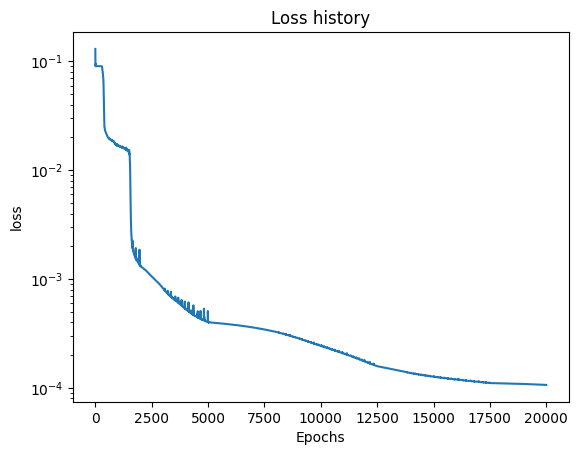

In [32]:
# Save model checkpoint to this path
checkpoint_filepath = CHEKPOINT_PATH

# Initialize model
model = init_model()


# Piecewise decay of the learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(EPOCH_CHECKPOINTS_CHANGE_LEARNING_RATE,LEARNING_RATE)

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)


# Define one training 
@tf.function # Defining the training step as a tensorflow function will increase the speed of training and optimize the memory used
def train_step(optimizer):

    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_b, X_0)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


# Number of training epochs
N = NUMBER_TRAINING_EPOCHS

# loss history
hist = []

# Start timer
t0 = time.time()

# print model summary
model.summary()

################ For each training step ################
for i in range(N+1):

    # training step
    loss = train_step(optim)

    # Append current loss to hist
    hist.append(loss.numpy())

    # Print current loss after iterations
    if i%PRINT_LOSS_INTERVAL == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
    # save model checkpoint
    if i%CHECKPOINT_ITERATIONS==0 and i!=N:
        model.save(f'{checkpoint_filepath}_{i}.h5')
        print(f'Model iter[{i}] saved in file {checkpoint_filepath}{i}.h5')


################ Save the Trained Model ################
model.save(f'{checkpoint_filepath}_LastTrained.h5')
print(f'Model iter[{i}] saved in file {checkpoint_filepath}{i}.h5')

################ Print computation time ################
print('\nComputation time: {} seconds'.format(time.time()-t0))

################ Plot loss history ################
if PLOT_LOSS_HISTORY:
    plt.plot(hist)
    plt.title("Loss history")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.yscale('log')
    plt.show()
    


# Show Solution 
(This plot example is for 2D time dependent plots)

In [1]:
timesplit = 30 # number of plots in the time interval
resolution = 100 # number of points per axis
# generate input for the NN
x = np.linspace(lb[1],ub[1],resolution)
y = np.linspace(lb[2],ub[2],resolution)
t = np.linspace(lb[0],ub[0],timesplit)
X = []
for timep in t:
  for xp in x:
    for yp in y:
      X.append([timep,xp,yp])

# predict the solution
print("Predict solution:")
y_pred = model.predict(X)


# reshape the solutions
y_pred = np.array(y_pred).reshape(len(t),len(x),len(y)).T



# for each timepoint create plot
def show_prediction(timepoint):
    plt.imshow(y_pred[:,:,timepoint], cmap='hot',extent=[lb[1],ub[1],lb[2],ub[2]])
    plt.colorbar()
    plt.title(f"t={round(t[timepoint],2)}")
    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.show()

# plot the solution in an interactive plot
interact(show_prediction, timepoint=IntSlider(min=0, max=len(t)-1, step=1, value=0))


NameError: name 'np' is not defined